# Otoczka wypukła

In [1]:
import numpy as np
import pandas as pd
from bitalg.tests.test2 import Test
from bitalg.visualizer.main import Visualizer

### Przykładowe zastosowanie narzędzia do wizualizacji

### Wprowadzenie

Czym jest otoczka wypukła?  
Podzbiór płaszczyzny $Q$ nazywamy wypukłym iff, gdy dla dowolnej pary punktów $p, q \in Q$ odcinek $\overline{pq}$ jest całkowicie zawarty w $Q$.  
Otoczka wypukła $\mathcal{CH}(Q)$ zbioru $Q$ jest najmniejszym wypukłym zbiorem zawierającym $Q$.

### Zastosowania otoczku wypukłej

Otoczki wypukłe - w szczególności otoczki wypukłe w przestrzeni trójwymiarowej - są spotykane w różnych zastosowaniach. Na przykład używa się ich do przyspieszania wykrywania kolizji w animacji komputerowej. Przepuśćmy, że chcemy sprawdzić, czy dwa obiekty $\mathcal{P_1}$ i $\mathcal{P_2}$ przecinają się. Jeśli przez większość czasu odpowiedź na to pytanie jest negatywna, to opłaca się następująca strategia. Przybliżamy obiekty przez prostrze obiekty $\widehat{\mathcal{P_1}}$ i $\widehat{\mathcal{P_2}}$, które zawierały orginały. Jeśli chcemy sprwadzić, czy $\mathcal{P_1}$ i $\mathcal{P_2}$ przecinają się, najpierw sprawdzamy, czy przecinają się $\widehat{\mathcal{P_1}}$ i $\widehat{\mathcal{P_2}}$. Jeśli występuje ten przypadek, to powinniśmy wykonać test na orginalnych obiektach, który jest przepuszczalnie znacznie kosztowniejszy.  
Sprawdzanie przecięcia otoczek wypukłych jest bardziej skomplikowane niż dla sfer - choć mimo to łatwiejsze niż dla obiektów niewypukłych - ale otoczki wypukłe mogą dużo lepiej przybliżać większość obiektów.

## Generowanie losowych punktów na płaszczyźnie 

Zapoznaliśmy się i wiemy jak generowac losowe punkty na płaszczyźnie z laboratorium I (współrzędne rzeczywiste typu *double* - podwójna precyzja obliczeń). Przygotuj zestawy punktów, które będzie można użyć jako testowe dla algorytmów obliczania otoczki wypukłej.

Uzupełnij funkcję ```generate_uniform_points```.

In [2]:
def generate_uniform_points(left=-100, right=100, n=100):
    from random import uniform
    tab = []
    for i in range(n):
        x=uniform(left, right)
        y=uniform(left, right)
        tab.append((x, y))
    return tab

<span style="color:red">Ćw.</span> Wygeneruj $100$ losowych punktów w przestrzeni 2D o współrzędnych z przedziału $x \in \langle -100,100 \rangle$ oraz $y \in \langle -100,100\rangle$.

In [61]:
points_a = generate_uniform_points(-100, 100, 100000)

Zwizualizuj wygenerowane punkty.

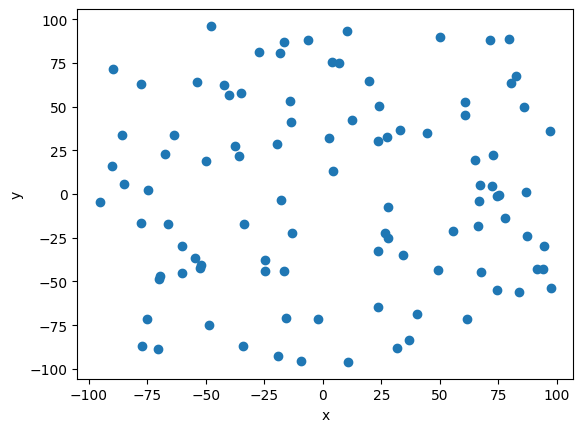

In [5]:
# visualize(points_a)
vis = Visualizer()
vis.add_point(points_a)
vis.show()

In [6]:
def generate_circle_points(O, R, n=100):
    from random import uniform
    from math import pi, cos, sin
    tab = []
    for i in range(n):
        t = uniform(0, 2*pi)
        x = R*cos(t) + O[0]
        y = R*sin(t) + O[1]
        tab.append((x, y))
    return tab

In [62]:
points_b = generate_circle_points((0, 0), 10, 100000)

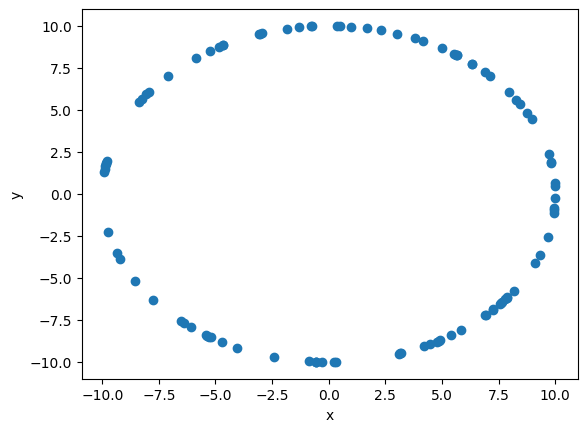

In [9]:
vis.clear()
vis.add_point(points_b)
vis.show()

In [10]:
def generate_rectangle_points(a=(-10, -10), b=(10, -10), c=(10, 10), d=(-10, 10), n=100):
    from random import uniform, randint
    tab = []
    for i in range(n):
        edge = randint(0,3)
        if edge == 0:
            x = uniform(a[0], b[0])
            tab.append((x, a[1]))
        elif edge == 1:
            y = uniform(b[1], c[1])
            tab.append((b[0], y))
        elif edge == 2:
            x = uniform(d[0], c[0])
            tab.append((x, d[1]))
        elif edge == 3:
            y = uniform(a[1], d[1])
            tab.append((a[0], y))
        


    return tab


In [63]:
points_c = generate_rectangle_points(
    (-10, -10), (10, -10), (10, 10), (-10, 10), 100000)

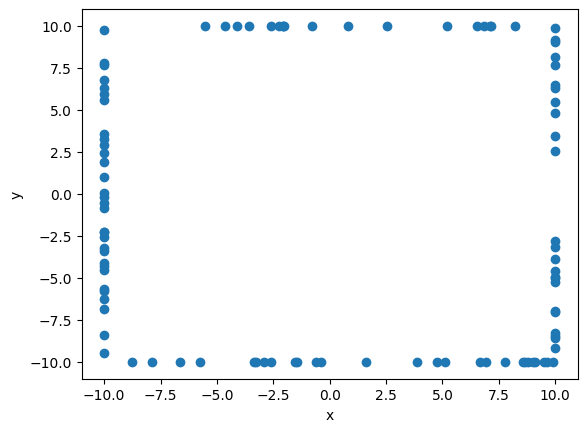

In [13]:
vis.clear()
vis.add_point(points_c)
vis.show()

In [15]:
def generate_square_points(a=(0, 0), b=(10, 0), c=(10, 10), d=(0, 10),
                           axis_n=25, diag_n=20):
    from random import uniform
    tab=[a,b,c,d]
    for i in range(axis_n):
        x = uniform(a[0], b[0])
        tab.append((x, a[1]))
    for i in range(axis_n):
        y = uniform(a[1], d[1])
        tab.append((a[0], y))
    for i in range(diag_n):
        x = uniform(a[0], c[0])
        y = x*((a[1]-c[1])/(a[0]-c[0]))+a[1]-a[0]*((a[1]-c[1])/(a[0]-c[0]))
        tab.append((x, y))
    for i in range(diag_n):
        x = uniform(d[0], b[0])
        y = x*((d[1]-b[1])/(d[0]-b[0]))+d[1]-d[0]*((d[1]-b[1])/(d[0]-b[0]))
        tab.append((x, y))
        
    return tab

In [64]:
points_d = generate_square_points(
    (0, 0), (10, 0), (10, 10), (0, 10), 25000, 20000)

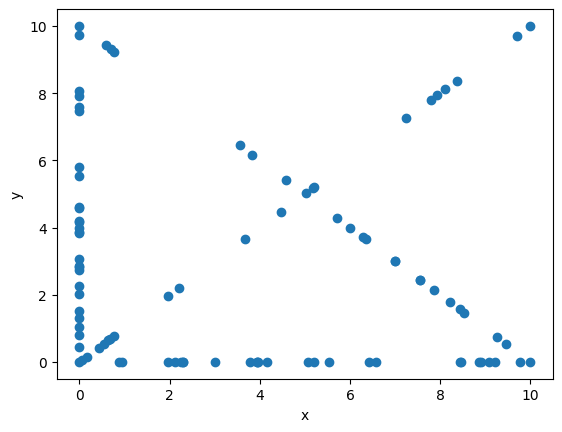

In [17]:
vis.clear()
vis.add_point(points_d)
vis.show()

In [18]:
def mat_det_3x3(a, b, c):
    return (a[0]*b[1]+a[1]*c[0]+b[0]*c[1]-b[1]*c[0]-a[1]*b[0]-a[0]*c[1])

## Algorytm Grahama oraz algorytm Jarvisa

Po przygotowaniu przykładowych zbiorów danych i ich zwizualizowaniu, chcemy zobaczyć jak buduje się dla nich otoczka wypukła z wykorzystaniem różnych algortymów.  
W tych dwóch algorytmach potrzebna będzie funkcja którą już dobrze znamy, czyli funkcja, która sprawdza po której stornie prostej znajduje się punkt.  
Dla każdego algorytmu trzeba będzie zaimplementować dwie funkcje obliczające otoczkę wypukłę, ze względu, że jedna z nich będzie miała możliwość wyświetlania kroków postępowania w algorytmie. Druga funkcja będzie uzyteczna do porównywania czasów dla różnych zbiorów danych i względęm algorytmów.  
W graficznej funkcji danego algorytmu, jednym kolorem powinny być zaznaczone wszystkie punkty zbioru wyjściowego, drugim kolorem boki aktualne rozpatrywane, a trzecim boki wielokąta otoczki. Po zakończeniu wyznaczania otoczki, wierzchołki otoczki powinny być wyróżnione (osobnym kolorem bądź kształtem).  

### Algorytm Grahama

Algorytm Grahama tworzy otoczkę wypukłą poprzez utrzymywanie stosu $S$, w którym znajdują się punkty, które mogą, ale nie muszą tworzyć otoczki wypukłej. Za każdym razem jest wstawiany na stos (push) jeden punkt z zbioru punktów $Q$ i jest on usuwany ze stosu (pop), jeżeli nie jest punktem $\mathcal{CH}(Q)$. Kiedy algorytm kończy się, stos $S$ zawiera tylko punkty otoczki wypukłej $\mathcal{CH}(Q)$ w kierunku przeciwnym do ruchu wskazówek zegera.

---

Procedura $\mathtt{Graham-Build(Q)}$ przyjmuje zbiór punktów $Q$, gdzie $|Q| \geq 3$. Wywołuje ona funkcję $\mathtt{TOP(S)}$, która zwraca punkt z góry stosu bez zmieniania $S$ oraz
$\mathtt{NEXT-TO-TOP(S)}$, która zwraca punkt ponieżej góry stosu $S$, bez zmieniania stosu. Funkcja $\mathtt{PUSH(p, S)}$ wstawia punkt $p$ na stos $S$. Funkcja $\mathtt{POP(p, S)}$ usuwa punkt $p$ ze stosu $S$.

$\mathtt{Graham-Build(Q)}$  
1)  niech $p_0$ będzie punktem w zbiorze Q z najmniejszą współrzędną $y$,  
    oraz najmniejszą współrzędną $x$ w przypadku, gdy wiele punktów ma tą samą współrzędną $x$  
    
2)  nich $\mathtt{\langle p_1, p_2, \dots, p_m \rangle}$ będzie pozostałym zbiorem punktów w $Q$ posortowanym  
    zgodnie z przeciwnym ruchem wskazówek zegara wokół punktu $p_0$  
    (jeżeli więcej niż jeden punkt ma ten sam kąt to usuwamy wszystkie punkty  
     z wyjątkiem tego najbardziej oddalonego od $p_0$)  
3) stwórz pusty stos $S$  
4) $\mathtt{PUSH(p_0, S)}$
5) $\mathtt{PUSH(p_1, S)}$
6) $\mathtt{PUSH(p_2, S)}$
7) **for** $i = 3$ **to** m  
8) &emsp;**while** kąt utworzony przez $\mathtt{NEXT-TO-TOP(S)}$, $\mathtt{TOP(S)}$ oraz $p_i$ tworzy lewostronny skręt
9) &emsp;&emsp;$\mathtt{POP(S)}$
10) &emsp;$\mathtt{PUSH(p_i, S)}$
11) **return** $S$


---

Lewostronny skręt oznacza, że dla trzech kolejnych punktów $a, b, c$, punkt $b$ leży po lewej stronie prostej $ac$.  
  

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```graham_algorithm```, która oblicza otoczkę wypukłą korzystając z algorytmu Grahama.

In [86]:
def dist(a, b):
    return np.sqrt((b[0]-a[0])**2+(b[1]-a[1])**2)
def partition(arr, root, low, high):
    i = (low-1)        
    pivot = arr[high]     
 
    for j in range(low, high):
        if orient(root, arr[j], pivot) == 1 or (orient(root, arr[j], pivot) == 0 and dist(root, arr[j]) > dist(root, pivot)):
            i = i+1
            arr[i], arr[j] = arr[j], arr[i]
    arr[i+1], arr[high] = arr[high], arr[i+1]
    return (i+1)
def quickSort(arr, root, low, high):
    if len(arr) == 1:
        return arr
    if low < high:
        pi = partition(arr, root, low, high)
        quickSort(arr, root, low, pi-1)
        quickSort(arr, root, pi+1, high)
def orient(a, b, c,eps=10**-13):
    d = mat_det_3x3(a, b, c)
    if d > eps:
        return 1
    elif d < -eps:
        return -1
    else:
        return 0
    
def Graham(points_raw):
    
    if len(points_raw)<=3:
        return points_raw
    points = points_raw.copy()
    root = min(points, key = lambda k: (k[1],k[0]))
    
    points.remove(root)
    quickSort(points, root, 0, len(points)-1)
    points = [root] + points

    stack = [] 
    stack.append(points[0])
    stack.append(points[1])
    stack.append(points[2])
    i = 3
    while i < len(points):
        
        if orient(stack[-2], stack[-1], points[i]) == 0:
            stack.pop()
            stack.append(points[i])
            i = i + 1    
        elif orient(stack[-2], stack[-1], points[i]) == 1:
            stack.append(points[i])
            i = i + 1
        else:
            stack.pop()

    if orient(stack[-2], stack[-1], root) == 0:
        stack.pop()
        
    lines = [(stack[i], stack[i+1]) for i in range(len(stack)-1)]
    lines.append([stack[-1], stack[0]])
    
            
    return stack

Przetestuj swoją implementacje algorytmu Grahama, by sprawdzić czy poprawnie obliczana jest otoczka.

In [18]:
Test().runtest(1, Graham)

Lab 2, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: WRONG ANSWER
		Output:   [(-0.00027969503264589635, -0.9999999608853436), (0.0005553495142406567, -0.9999998457934466), (0.0016519268116104392, -0.9999986355679737), (0.002605435221465321, -0.9999966058478933), (0.0030932882850060305, -0.9999952157723485), (0.004228777142265965, -0.9999910586819669), (0.005182331123160356, -0.9999865716319044), (0.005687014754754341, -0.99...
		Expected: [(-0.9998456727740328, 0.017567886470535515), (-0.9999066111976357, 0.013666341253615146), (-0.9999097856527912, 0.013432071909764622), (-0.9999131277882609, 0.01318092852180958), (-0.9999151687762107, 0.013025177589655271), (-0.9999236593517755, 0.012356191506870385), (-0.9999295253527812, 0.01187199763146682), (-0.9999341564245192, 0.011475313310...
	Test 6: Passed
	Test 7: Passed
	Test 8: WRONG ANSWER
		Output:   [(3.5192864828680724e-10, -9.999737017848142e-10), (-9.928918315961275e-10, 9.950268365661419e-10)]
	

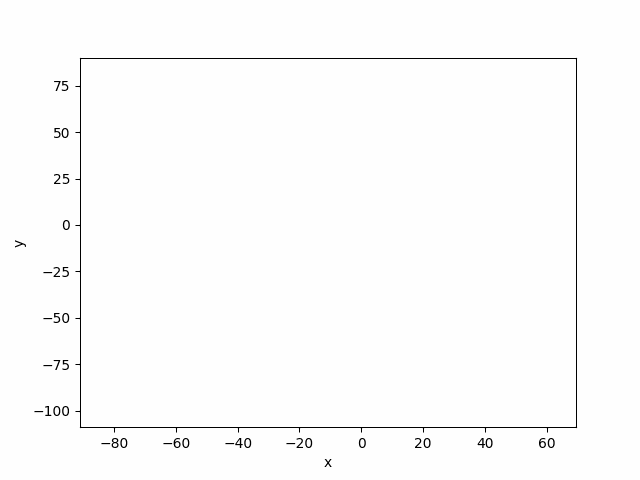

In [68]:
def Graham_draw(points_raw):
    vis.clear()
    vis.add_point(points_raw)
    if len(points_raw)<=3:
        return points_raw
    points = points_raw.copy()
    root = min(points, key = lambda k: (k[1],k[0]))
    
    points.remove(root)
    quickSort(points, root, 0, len(points)-1)
    points = [root] + points

    stack = [] 
    stack.append(points[0])
    stack.append(points[1])
    stack.append(points[2])

    lines=[]
    vis.add_point(stack, color='red')
    lines.append(vis.add_line_segment([stack[0],stack[1]],color = 'blue'))
    lines.append(vis.add_line_segment([stack[1],stack[2]],color = 'blue'))
    
    i = 3
    while i < len(points):
        if orient(stack[-2], stack[-1], points[i]) == 0:
            vis.remove_figure(lines[-1])
            lines.pop()
            vis.add_point(stack.pop(), color='green')
            
            stack.append(points[i])
            vis.add_point(points[i], color='red')
            lines.append(vis.add_line_segment([stack[-1],stack[-2]],color = 'blue'))

            i = i + 1    
        elif orient(stack[-2], stack[-1], points[i]) == 1:
            stack.append(points[i])
            vis.add_point(points[i], color='red')
            lines.append(vis.add_line_segment([stack[-1],stack[-2]],color = 'blue'))
            i = i + 1
        else:
            vis.remove_figure(lines[-1])
            lines.pop()
            vis.add_point(stack.pop(), color='green')

    if orient(stack[-2], stack[-1], root) == 0:
        vis.remove_figure(lines[-1])
        lines.pop()
        vis.add_point(stack.pop(), color='green')
        
    lines = [(stack[i], stack[i+1]) for i in range(len(stack)-1)]
    lines.append([stack[-1], stack[0]])
    
    vis.add_line_segment([stack[-1],stack[0]],color = 'blue')
    return stack

Graham_draw(points_a)
#stworzenie gifa dla 100 punktów zajmuje ponad 2 min dlatego zalecane jest użycie okolo 15 pkt
vis.show_gif(interval=200)  

Czas: 5.192847013473511 s
Ilość punktów otoczki: 37


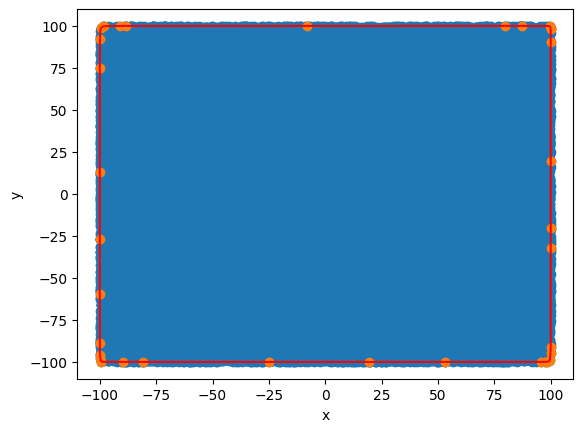

In [65]:
import time
start_time = time.time()
graham_points_a=Graham(points_a)
print("Czas:", time.time() - start_time, "s")
print("Ilość punktów otoczki:", len(graham_points_a))
vis.clear()
vis.add_point(points_a)
vis.add_point(graham_points_a)
vis.add_line_segment([(graham_points_a[i], graham_points_a[i+1]) for i in range(len(graham_points_a)-1)],  color='red')
vis.add_line_segment([graham_points_a[-1], graham_points_a[0]],  color='red')
vis.show()

Zbiór danych B

Czas: 1.8168342113494873 s
Ilość punktów otoczki: 99167


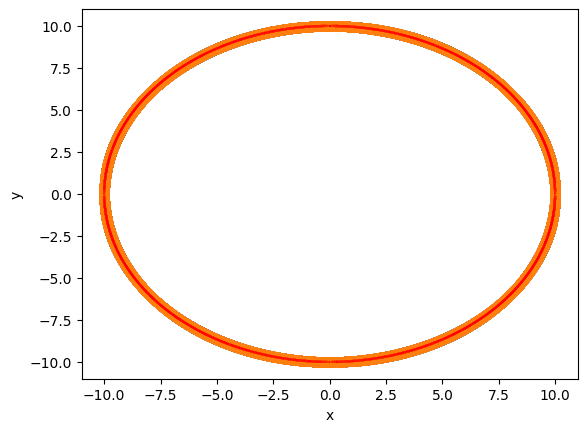

In [85]:
import time
start_time = time.time()
graham_points_b=Graham(points_b)
print("Czas:", time.time() - start_time, "s")
print("Ilość punktów otoczki:", len(graham_points_b))
vis.clear()
vis.add_point(points_b)
vis.add_point(graham_points_b)
vis.add_line_segment([(graham_points_b[i], graham_points_b[i+1]) for i in range(len(graham_points_b)-1)], color='red')
vis.add_line_segment([graham_points_b[-1], graham_points_b[0]], color ='red')
vis.show()

Zbiór danych C

In [82]:
import time
start_time = time.time()
graham_points_c=Graham(points_c)
print("Ilość punktów otoczki:", len(graham_points_c))
print("Czas:", time.time() - start_time, "s")
vis.clear()
vis.add_point(points_c)
vis.add_point(graham_points_c)
vis.add_line_segment([(graham_points_c[i], graham_points_c[i+1]) for i in range(len(graham_points_c)-1)], color='red')
vis.add_line_segment([graham_points_c[-1], graham_points_c[0]], color ='red')
vis.show()

IndexError: list index out of range

Zbiór danych D

Ilość punktów otoczki: 4
Czas: 13.837443351745605 s


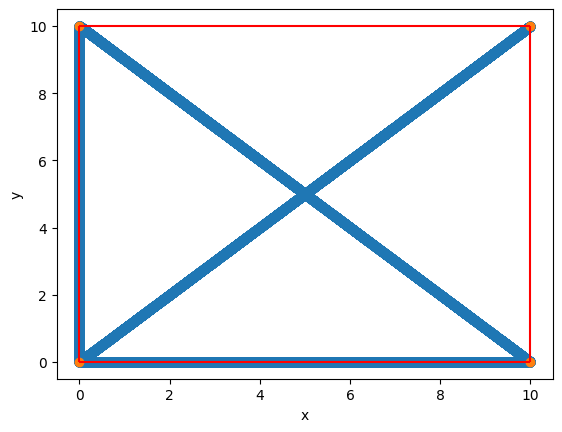

In [68]:
import time
start_time = time.time()
graham_points_d=Graham(points_d)
print("Ilość punktów otoczki:", len(graham_points_d))
print("Czas:", time.time() - start_time, "s")
vis.clear()
vis.add_point(points_d)
vis.add_point(graham_points_d)
vis.add_line_segment([(graham_points_d[i], graham_points_d[i+1]) for i in range(len(graham_points_d)-1)], color='red')
vis.add_line_segment([graham_points_d[-1], graham_points_d[0]], color ='red')
vis.show()

### Algorytm Jarvisa

Algorytm Jarvisa oblicza otoczkę wypukłą dla zbioru punktów $Q$ przez technikę zwaną owijaniem paczki (*package wrapping*) lub owijaniem prezentu (*gift wrapping*). Algorytm Jarvisa buduje sekwencję $H = \langle p_1, p_2, \dots, p_m \rangle$ będącą wierzchołkami $\mathcal{CH}(Q)$. Zaczynamy od punktu $p_0$, następny punkt $p_1$ w otoczce wypukłej ma najmniejszy kąt w odniesieniu do $p_0$ (w przypadku takiego samego kąta - wybiera się punkt najdalej od $p_0$). Podobnie, gdy $p_2$ ma najmniejszy kąt w odniesieniu do $p_1$, itd.. Zauważyć warto, że możemy tym sposobem obliczyć lewy i prawy łańcuch otoczki wypukłej $\mathcal{CH}(Q)$. Lewy łańcuch buduje się podobnie. Gdy osiągniemy najwyższy wierzchołej w prawym łańcuchu $p_k$, wybieramy wierzchołek $p_{k+1}$, który ma najmniejszy kąt w odniesieniu do $p_k$, ale od ujemnej osi-$x$. Można zaimplementować algorytm Jarvisa bez konstruowania pomocniczych łańcuchów - lewego i prawego. Taka implementacja utrzymuje śledzenie kąta ostatniej strony otoczki wypukłej i wymaga sekwencji kątów boków otoczki tylko rosnącej. (Patrząc na trzy ostatnie punkty jesteśmy w stanie obliczyć jaki punkt należy włączyć do $\mathcal{CH}(Q)$ w zależności od budowanego punktu)

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```jarvis_algorithm```, która oblicza otoczkę wypukłą korzystając z algorytmu Jarvisa.

In [39]:
def Jarvis(points): 
      
    
    root = min(points, key = lambda k: (k[1], k[0]))
    hull = [] 
    pointOnHull = root
    endpoint = points[0]
    
    while(True): 
          
        hull.append(pointOnHull) 
  
        endpoint = points[0]
        for i in range(len(points)): 
            if (orient(pointOnHull, endpoint, points[i]) == -1) or orient(pointOnHull, points[i], endpoint) == 0 and dist(pointOnHull, points[i]) > dist(pointOnHull, endpoint): 
                endpoint = points[i] 

        pointOnHull = endpoint 
  
        if pointOnHull == root: 
            break
            
    lines = [(hull[i], hull[i+1]) for i in range(len(hull)-1)]
    lines.append([hull[-1], hull[0]])
    
    
  
    return hull

Przetestuj swoją implementacje algorytmu Jarvisa, by sprawdzić czy poprawnie obliczana jest otoczka.

In [79]:
Test().runtest(2, Jarvis)

Lab 2, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: WRONG ANSWER
		Output:   [(0.00022143953625450066, -0.9999999754822656), (0.0018310907166059663, -0.9999983235519886), (0.004674316600857559, -0.9999890753224832), (0.005440630206227845, -0.9999851996619545), (0.009618119447759222, -0.9999537448193735), (0.020715290007359437, -0.9997854153566709), (0.021967448410721985, -0.9997586864890559), (0.027776914597739028, -0.99961...
		Expected: [(0.07000085966667666, -0.9975469310493248), (0.1380455179058054, -0.9904258856603648), (0.1424763509767261, -0.9897982064099514), (0.15459183329796522, -0.9879784233866518), (0.1639978958115513, -0.9864606886082099), (0.1670602636719769, -0.9859466863384904), (0.16769119087644196, -0.9858395734106238), (0.17337673263098613, -0.9848555775250519), (...
	Test 6: Passed
	Test 7: Passed
	Test 8: 

KeyboardInterrupt: 

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```jarvis_algorithm_draw```, która oblicza otoczkę wypukłą korzystając z algorytmu Jarvisa z dodatkową opcją wyświetlania kroków algorytmu.

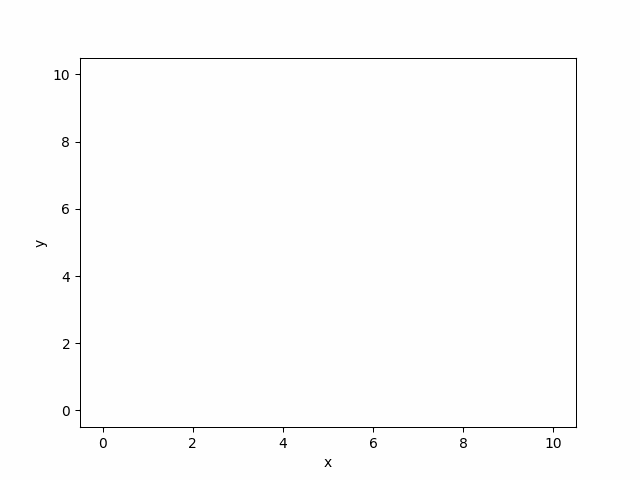

In [35]:
def Jarvis_draw(points): 
    vis.clear()
    vis.add_point(points)
    
    root = min(points, key = lambda k: (k[1], k[0]))
    hull = [] 
    pointOnHull = root
    endpoint = points[0]
    
    while(True): 
          
        hull.append(pointOnHull) 
        vis.add_point(pointOnHull,color='red')
        if len(hull)>1:
            vis.add_line_segment([hull[-1],hull[-2]],color='blue')
  
        endpoint = points[0]
        for i in range(len(points)): 
            if (orient(pointOnHull, endpoint, points[i]) == -1) or orient(pointOnHull, points[i], endpoint) == 0 and dist(pointOnHull, points[i]) > dist(pointOnHull, endpoint): 
                endpoint = points[i] 

        pointOnHull = endpoint 
  
        if pointOnHull == root: 
            break
            
    lines = [(hull[i], hull[i+1]) for i in range(len(hull)-1)]
    lines.append([hull[-1], hull[0]])
    
    
    vis.add_line_segment([hull[-1],hull[0]],color='blue')
    return hull

Jarvis_draw(points_d)
vis.show_gif(interval=200)  

Zwizualizuj swoją implementację algorytmu.

Zbiór danych A

Ilość punktów otoczki: 30
Czas: 7.974003076553345 s


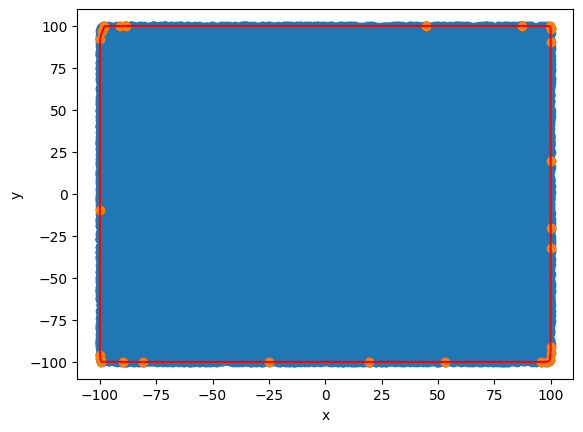

In [69]:
import time
start_time = time.time()
jarvis_points_a=Jarvis(points_a)
print("Ilość punktów otoczki:", len(jarvis_points_a))
print("Czas:", time.time() - start_time, "s")
vis.clear()
vis.add_point(points_a)
vis.add_point(jarvis_points_a)
vis.add_line_segment([(jarvis_points_a[i], jarvis_points_a[i+1]) for i in range(len(jarvis_points_a)-1)],color='red')
vis.add_line_segment([jarvis_points_a[-1], jarvis_points_a[0]],color='red')
vis.show()

Zbiór danych B

Ilość punktów otoczki: 9962
Czas: 250.5212230682373 s


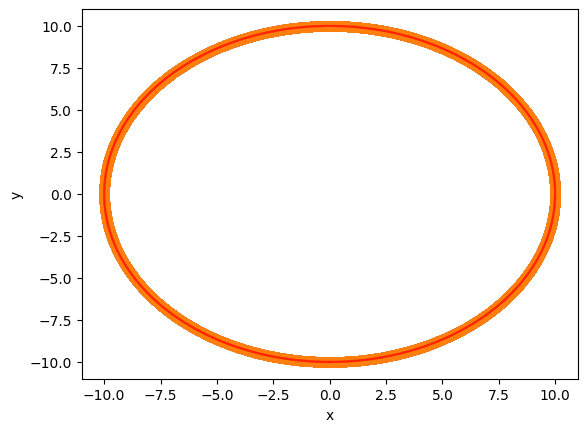

In [58]:
import time
start_time = time.time()
jarvis_points_b=Jarvis(points_b)
print("Ilość punktów otoczki:", len(jarvis_points_b))
print("Czas:", time.time() - start_time, "s")
vis.clear()
vis.add_point(points_b)
vis.add_point(jarvis_points_b)
vis.add_line_segment([(jarvis_points_b[i], jarvis_points_b[i+1]) for i in range(len(jarvis_points_b)-1)],color='red')
vis.add_line_segment([jarvis_points_b[-1], jarvis_points_b[0]],color='red')
vis.show()

Zbiór danych C

Ilość punktów otoczki: 8
Czas: 3.2027385234832764 s


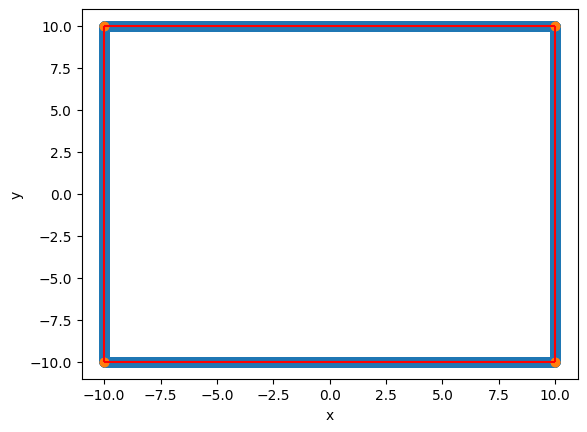

In [70]:
import time
start_time = time.time()
jarvis_points_c=Jarvis(points_c)
print("Ilość punktów otoczki:", len(jarvis_points_c))
print("Czas:", time.time() - start_time, "s")
vis.clear()
vis.add_point(points_c)
vis.add_point(jarvis_points_c)
vis.add_line_segment([(jarvis_points_c[i], jarvis_points_c[i+1]) for i in range(len(jarvis_points_c)-1)],color='red')
vis.add_line_segment([jarvis_points_c[-1], jarvis_points_c[0]],color='red')
vis.show()

Zbiór danych D

Ilość punktów otoczki: 4
Czas: 1.5858416557312012 s


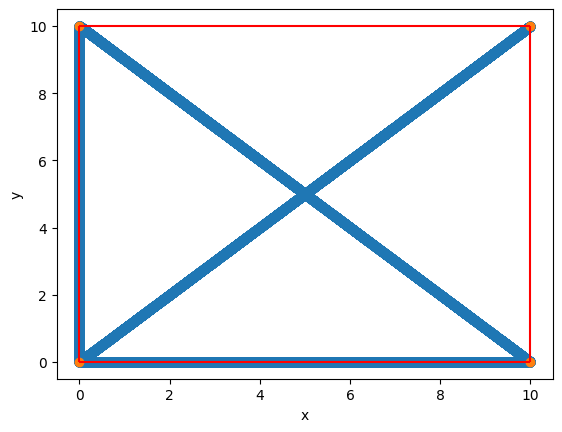

In [71]:
import time
start_time = time.time()
jarvis_points_d=Jarvis(points_d)
print("Ilość punktów otoczki:", len(jarvis_points_d))
print("Czas:", time.time() - start_time, "s")
vis.clear()
vis.add_point(points_d)
vis.add_point(jarvis_points_d)
vis.add_line_segment([(jarvis_points_d[i], jarvis_points_d[i+1]) for i in range(len(jarvis_points_d)-1)],color='red')
vis.add_line_segment([jarvis_points_d[-1], jarvis_points_d[0]],color='red')
vis.show()


---

Po zobaczeniu i przetestowaniu wstępnie zbiorów danych, przyszła kolej na porównanie czasów działania dla różnych danych. Do tego potrzebujemy bardziej miarodajnych zbiorów danych.  
<span style="color:red">Ćw.</span> Stwórz zmodyfikowane zbiory danych A, B, C oraz D - tak jak uważasz za słuszne.

In [ ]:
# prepare your data to time-test

Po przygotowaniu zbioru danych, dokonaj porównania czasowego  
<span style="color:red">Ćw.</span> Porównaj zmodyfikowane zbiory danych A, B, C oraz D dla algorytmów Grahama i Jarvisa.

In [ ]:
# compare your sets of data 

WNIOSKI HERE  
W sprawozdaniu napisz, czy Twój program działał poprawnie dla wszystkich zbiorów
danych oraz opisz krótko wnioski dotyczące działania algorytmu dla poszczególnych
zbiorów. Napisz, dlaczego wg Ciebie zaproponowano takie zbiory punktów? Które ze
zbiorów mogły stwarzać problemy w działaniu algorytmów? Jeśli tak, to jakie i
dlaczego? Porównaj czasy działania obu algorytmów w zależności od liczby punktów
w poszczególnych zbiorach (A, B, C, D). Dołącz wybrane, istotne ilustracje.

Bibliografia:
- Wprowadzenie do algorytmów wydanie 3, Thomas H. Cormen, Charles E. Leiserson, Ronald L. Rivest, Stein Clifford
